In [1]:
from torch import optim
import sys

# Function handle that returns an optimizer
def get_optimizer(model, name='adam', lr=0.001, momentum=0.9):
    if name == 'adam':
        return optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    elif name == 'sgd':
        return optim.SGD(model.parameters(), lr=lr,momentum=momentum)
    else:
        print(f'[-] Unknown optimizer {name}')
        sys.exit(-1)

# Function handle that updates the learning rate
# (note this is a dummy implementation that does nothing)
def get_lrs(optimizer, name='ReduceLROnPlateau'):
    if name == "ReduceLROnPlateau":
        return optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5)

    elif name == "StepLR":
        return optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    elif name == 'MultiStepLR':
        return optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,30], gamma=0.1)

    else:
        print(f"[-] Unknown scheduler {name}")
        sys.exit(-1)

In [2]:
import os
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights, resnet
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights, mobilenetv3

# Global Variables
local = True
data_path = 'datasets/deeplearningproject/'
if not local:
    data_path = os.path.join('/', data_path)
images_path = os.path.join(data_path, 'train-jpg')
label_path = os.path.join(data_path, 'train_classes.csv')


network_weights = MobileNet_V3_Small_Weights.DEFAULT
encoder = mobilenet_v3_small(weights=network_weights)
# network_weights = ResNet50_Weights.DEFAULT
# encoder = resnet50(weights=network_weights)
preprocess = network_weights.transforms()


loss_function = nn.BCELoss()
optimizer_name = 'adam'
lrs_name = 'StepLR'


batch_size = 40
epochs = 20
workers = 4

accuracy_threshold = 0.5
data_size = 500

In [3]:
def reset_parameters(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            torch.nn.init.constant_(m.weight, 1) # Why 1?
            torch.nn.init.constant_(m.bias, 0) # Why 0?
        elif isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)

#reset_parameters(model)

In [4]:
import torch.nn.functional as F


def Net():
    for param in encoder.parameters():
        param.requires_grad = False

    if isinstance(encoder, mobilenetv3.MobileNetV3):
        decoder = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=576,out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=17),
            nn.Sigmoid()
        )
        for param in decoder.parameters():
            param.requires_grad=True

        encoder.classifier = decoder
    elif isinstance(encoder, resnet.ResNet):
        decoder = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=2048,out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=17),
            nn.Sigmoid()
        )
        for param in decoder.parameters():
            param.requires_grad=True

        encoder.fc = decoder
    else:
        print(f"[-] Unknown encoder Model: {type(encoder)}")

    return encoder


In [5]:
def accuracy(scores, yb):
    # print("scores", scores.dtype)
    # print("yb", yb.dtype)
    # Binarize predictions via thresholding
    scores[scores>=accuracy_threshold] = 1
    scores[scores<accuracy_threshold] = 0

    return (scores == yb).float().mean()

#print('Accuracy', accuracy(scores,labels))

# loss_func = F.cross_entropy

#loss = loss_func(scores, labels)
#print('Loss', loss)

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer
from time import process_time
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
import torch
import torchvision.transforms as transforms


class MultilabelDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, target_transform=None, preprocessor=None):
        self.img_dataframe = dataframe  # pd.read_csv(annotation_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.preprocessor = preprocessor

        # Encode labels
        tags = ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn',
         'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming',
         'selective_logging', 'blow_down']
        split_tags = [row.split(" ") for row in self.img_dataframe["tags"]]
        mlb = MultiLabelBinarizer(classes=tags)
        mlb.fit(split_tags)
        self.img_labels = mlb.transform(split_tags).astype('float32')  # BCELoss does not accept integers *for some reason*

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # print(idx)
        # print(self.img_dataframe[idx-10:idx+10])
        img_path = os.path.join(self.img_dir, self.img_dataframe.iloc[idx, 0] + '.jpg')
        # print(img_path)
        pre_time = process_time()
        image = read_image(img_path)
        image = image [:3,:,:] #remove alpha channel
        loaded_time = process_time()

        if self.preprocessor != None:
            image = image/255 #required for preprocessor | normalize each picture
            image = self.preprocessor(image)
        else:
            image = 2 * (image/255 - 0.5) #normalize each picture

        processed_time = process_time()
        labels = self.img_labels[idx]

        transform_time = process_time()
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels = self.target_transform(labels)

        post_time = process_time()

        # print("load", loaded_time - pre_time, "processing", processed_time - loaded_time, "labels", transform_time - processed_time, "transform", post_time - transform_time)
        # print("total", post_time - pre_time)
        return image, labels

In [7]:
from sklearn.model_selection import train_test_split


labels = pd.read_csv(label_path)
labels = labels.sample(frac=1)
train_data, test_daa = train_test_split(labels[:data_size], train_size=0.9)

trainset = MultilabelDataset(
    train_data,
    images_path,
    preprocessor=preprocess
)

testset = MultilabelDataset(
    test_daa,
    images_path,
    preprocessor=preprocess
)

In [8]:
from torch import optim
import matplotlib.pyplot as plt

# Function to fit a model
def fit(model,
        opt,
        lr_scheduler,
        loss_func,
        bs=256,
        epochs=1,
        batches_per_epoch=None, # Default: Use entire training set
        show_summary=True,
        workers=0):

  # Set up data loaders
  if batches_per_epoch == None:
    # Use all images
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=workers, persistent_workers=workers)
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=workers, persistent_workers=workers)
    batches_per_epoch = len(train_dl)
  else:
    # Only use a subset of the data
    subset_indices = list(range(batches_per_epoch*bs))
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=workers, persistent_workers=workers)

    # Use one fourth for validation
    subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=workers, persistent_workers=workers)

  # For book keeping
  train_loss_history = []
  valid_loss_history = []
  plot_time_train = []
  plot_time_valid = []

  # Index of current batch
  t = 1

  # Total number of batches
  T = batches_per_epoch * epochs
  
  print('Epochs:',epochs,'Batches per epoch:',batches_per_epoch,'Total number of batches',T)
  
  # Get initial validation loss and accuracy
  model.eval()
  with torch.no_grad():
    if torch.cuda.is_available():
        valid_acc = sum(accuracy(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
        valid_loss = sum(loss_func(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
        valid_loss_history.append(valid_loss.detach().cpu().numpy())
        plot_time_valid.append(t)
    else:
        valid_acc = sum(accuracy(model(xb), yb) for xb, yb in valid_dl) / len(valid_dl)
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl) / len(valid_dl)
        valid_loss_history.append(valid_loss.detach().cpu().numpy())
        plot_time_valid.append(t)

  # Train
  for epoch in range(epochs):
    model.train() # Train mode    

    for xb, yb in train_dl:

      # Forward prop      
      if torch.cuda.is_available():
        pred = model(xb.cuda())
        loss = loss_func(pred, yb.cuda())
      else:
        pred = model(xb)
        loss = loss_func(pred, yb) 

      # Book keeping
      train_loss_history.append(loss.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      # Backward prop (calculate gradient)
      loss.backward()
      
      # Update model parameters
      opt.step()
      opt.zero_grad()


      # Validation loss and accuracy
      if t % 10 == 0:
        model.eval() # Test mode
        with torch.no_grad():
            if torch.cuda.is_available():
                valid_acc = sum(accuracy(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
                valid_loss = sum(loss_func(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
            else:
                valid_acc = sum(accuracy(model(xb), yb) for xb, yb in valid_dl) / len(valid_dl)
                valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl) / len(valid_dl)
        
            valid_loss_history.append(valid_loss.detach().cpu().numpy())
            plot_time_valid.append(t-1)
            print('t',t,'lr',opt.param_groups[0]['lr'],'train loss',loss.detach().cpu().numpy(), 'val loss',valid_loss.detach().cpu().numpy(),'val accuracy', valid_acc.detach().cpu().numpy())
        
        model.train() # Back to train mode
    
    # Update learning rate once per epoch 
    lr_scheduler.step()

  # Summary
  if show_summary:
    plt.figure()
    lines = []
    labels = []
    l, = plt.plot(plot_time_train,train_loss_history)
    lines.append(l)
    labels.append('Training')
    l, = plt.plot(plot_time_valid,valid_loss_history)
    lines.append(l)
    labels.append('Validation')  
    plt.title('Loss')
    plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
    plt.show()

  return train_loss_history

Epochs: 20 Batches per epoch: 12 Total number of batches 240
t 10 lr 0.001 train loss 0.34635308 val loss 0.6630512 val accuracy 0.5507353
t 20 lr 0.001 train loss 0.30332893 val loss 0.59169126 val accuracy 0.6110294
t 30 lr 0.001 train loss 0.24348809 val loss 0.55130005 val accuracy 0.72352946
t 40 lr 0.001 train loss 0.23345858 val loss 0.5184516 val accuracy 0.7742647
t 50 lr 0.001 train loss 0.17749587 val loss 0.4842706 val accuracy 0.7889706
t 60 lr 0.001 train loss 0.26157343 val loss 0.44761214 val accuracy 0.8426471
t 70 lr 0.001 train loss 0.2159861 val loss 0.4189165 val accuracy 0.8661765
t 80 lr 0.001 train loss 0.21002366 val loss 0.38845813 val accuracy 0.8801471
t 90 lr 0.001 train loss 0.18471955 val loss 0.3551068 val accuracy 0.8933824
t 100 lr 0.001 train loss 0.15795308 val loss 0.33128828 val accuracy 0.9
t 110 lr 0.001 train loss 0.18058187 val loss 0.30958718 val accuracy 0.90808827
t 120 lr 0.001 train loss 0.16995987 val loss 0.2938745 val accuracy 0.9102942

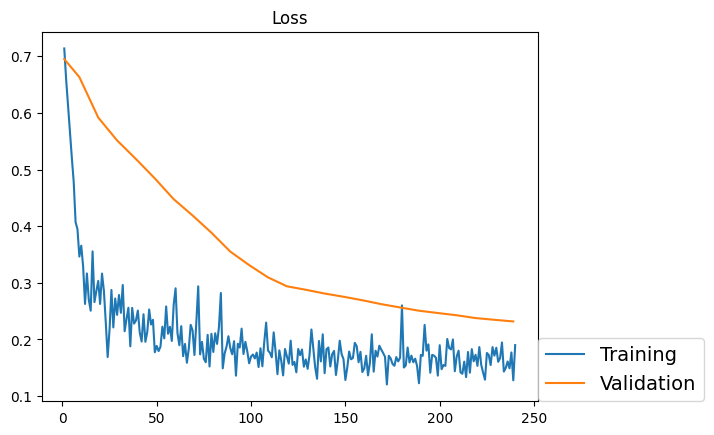

In [9]:
 # Re-initialize weights
#reset_parameters(model)
model = Net()
if torch.cuda.is_available():
    model = model.cuda()

optimizer = get_optimizer(model, optimizer_name)
lrs = get_lrs(optimizer, lrs_name)

# Train with defaul settings.
train_loss_history = fit(model, loss_func=loss_function,\
                         opt=optimizer, lr_scheduler=lrs, bs=batch_size, epochs=epochs, workers=workers)

In [10]:
train_dl = torch.utils.data.DataLoader(trainset)

for xb, yb in train_dl:
    y = model(xb.cuda())
    print(y)

tensor([[1.7632e-02, 9.8767e-01, 2.2975e-01, 8.9332e-01, 1.6540e-01, 5.3774e-02,
         1.5241e-01, 8.5214e-02, 5.6933e-03, 4.5339e-03, 7.7176e-02, 1.6496e-04,
         1.0851e-02, 1.5927e-03, 6.7519e-04, 3.9521e-03, 7.4131e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.9113e-02, 9.8631e-01, 2.6358e-01, 8.4172e-01, 1.5566e-01, 5.9377e-02,
         1.5355e-01, 8.5176e-02, 2.9816e-03, 6.1579e-03, 7.9278e-02, 9.5158e-05,
         7.6748e-03, 1.2783e-03, 5.2312e-04, 2.9429e-03, 3.4852e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.0130e-02, 9.8988e-01, 2.5821e-01, 8.7627e-01, 1.7298e-01, 9.3749e-02,
         1.8212e-01, 1.0331e-01, 7.5074e-03, 3.9942e-03, 1.1046e-01, 2.9536e-04,
         1.1830e-02, 2.0962e-03, 8.7715e-04, 6.0884e-03, 1.1308e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.6827e-02, 9.8506e-01, 2.0939e-01, 6.2321e-01, 1.0982e-01, 3.4450e-02,
         1.3853e-01, 6.8021e-02, 3.8765e-03, 7.3946e-03, 1.7099e

tensor([[4.8375e-02, 9.6598e-01, 1.8778e-01, 5.5026e-01, 1.1680e-01, 6.4899e-02,
         1.5964e-01, 1.0118e-01, 1.0285e-02, 1.3845e-02, 2.7688e-01, 5.1712e-04,
         1.6147e-02, 4.4713e-03, 1.5970e-03, 7.8762e-03, 2.5503e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.1136e-02, 9.8444e-01, 2.4358e-01, 7.1588e-01, 1.5725e-01, 5.6115e-02,
         1.4620e-01, 9.9134e-02, 5.2187e-03, 7.8356e-03, 1.4175e-01, 1.8890e-04,
         9.9052e-03, 2.1923e-03, 6.4293e-04, 3.4003e-03, 7.3422e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[2.4920e-02, 9.7826e-01, 2.7596e-01, 7.6666e-01, 1.7780e-01, 8.1629e-02,
         1.9610e-01, 1.4821e-01, 7.4829e-03, 1.0272e-02, 1.6895e-01, 3.7119e-04,
         1.3364e-02, 2.9607e-03, 1.6165e-03, 5.5685e-03, 1.5827e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.9578e-02, 9.7718e-01, 3.0348e-01, 8.5906e-01, 1.7180e-01, 8.5226e-02,
         2.0722e-01, 9.9362e-02, 7.4842e-03, 7.7809e-03, 8.4440e

tensor([[1.4797e-02, 9.8734e-01, 1.7135e-01, 8.3986e-01, 1.2799e-01, 5.3966e-02,
         9.2178e-02, 1.1329e-01, 6.5341e-03, 6.9910e-03, 9.8271e-02, 1.9299e-04,
         7.0832e-03, 2.2390e-03, 8.7831e-04, 4.4556e-03, 8.2905e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.7422e-02, 9.7297e-01, 2.1346e-01, 6.9272e-01, 1.8503e-01, 8.9719e-02,
         1.6852e-01, 1.3110e-01, 5.9021e-03, 1.4706e-02, 2.1312e-01, 3.4613e-04,
         1.3815e-02, 3.7989e-03, 1.4995e-03, 7.4080e-03, 1.6703e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.8051e-02, 9.7990e-01, 2.7408e-01, 6.4083e-01, 1.4873e-01, 9.0160e-02,
         1.6341e-01, 1.2217e-01, 5.5743e-03, 1.0296e-02, 2.0183e-01, 2.5789e-04,
         9.8983e-03, 2.6538e-03, 9.0186e-04, 5.2173e-03, 1.2154e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.5833e-02, 9.8265e-01, 2.2945e-01, 7.3200e-01, 1.4819e-01, 4.7645e-02,
         1.2119e-01, 7.1451e-02, 3.5561e-03, 7.8625e-03, 1.0584e

tensor([[4.0694e-02, 9.7682e-01, 2.1195e-01, 7.3446e-01, 2.4476e-01, 5.7955e-02,
         1.1539e-01, 9.3425e-02, 7.7319e-03, 1.3072e-02, 1.1442e-01, 4.4011e-04,
         1.2394e-02, 3.5191e-03, 1.2365e-03, 6.5043e-03, 1.8871e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[2.8484e-02, 9.9152e-01, 1.9484e-01, 8.5504e-01, 1.0053e-01, 6.4821e-02,
         1.4592e-01, 1.0347e-01, 5.7922e-03, 5.0316e-03, 9.7060e-02, 2.0274e-04,
         7.5410e-03, 2.1206e-03, 1.0506e-03, 6.6853e-03, 8.2705e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.7742e-02, 9.8361e-01, 2.6129e-01, 8.6081e-01, 2.0863e-01, 5.8540e-02,
         1.3960e-01, 1.0636e-01, 6.8127e-03, 5.6716e-03, 8.9750e-02, 2.3202e-04,
         1.1977e-02, 2.2527e-03, 8.9951e-04, 5.0343e-03, 1.1534e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[4.5499e-02, 9.8466e-01, 1.3584e-01, 7.0686e-01, 8.8150e-02, 2.4531e-02,
         7.8214e-02, 7.0292e-02, 4.2804e-03, 8.0920e-03, 8.3151e

tensor([[2.8661e-02, 9.7967e-01, 2.7960e-01, 7.5656e-01, 2.0897e-01, 5.4676e-02,
         1.2852e-01, 1.0515e-01, 9.5401e-03, 1.2274e-02, 1.0496e-01, 4.7927e-04,
         1.2115e-02, 5.1111e-03, 1.3669e-03, 5.8220e-03, 2.0821e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.4093e-02, 9.8875e-01, 2.1061e-01, 9.0302e-01, 2.1082e-01, 5.9587e-02,
         1.2381e-01, 7.5707e-02, 3.9163e-03, 4.1967e-03, 4.6636e-02, 1.8257e-04,
         6.7190e-03, 1.2217e-03, 5.6202e-04, 2.4479e-03, 4.4208e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[2.0627e-02, 9.8419e-01, 2.1322e-01, 6.3103e-01, 1.1547e-01, 4.5509e-02,
         1.3279e-01, 1.2140e-01, 3.7915e-03, 7.1707e-03, 2.0256e-01, 1.1758e-04,
         7.1681e-03, 1.7432e-03, 5.6584e-04, 3.0080e-03, 6.8586e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[2.4805e-02, 9.8829e-01, 2.1521e-01, 8.9883e-01, 1.4970e-01, 5.0165e-02,
         1.1949e-01, 1.1908e-01, 8.1066e-03, 4.9377e-03, 7.2308e

tensor([[3.6299e-02, 9.7401e-01, 2.3005e-01, 7.6594e-01, 1.7127e-01, 8.1400e-02,
         2.1998e-01, 8.4702e-02, 8.3156e-03, 1.2001e-02, 1.3203e-01, 4.2588e-04,
         1.4929e-02, 3.0212e-03, 1.1663e-03, 6.0493e-03, 1.7080e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.2284e-02, 9.8508e-01, 1.4148e-01, 6.2612e-01, 1.3106e-01, 2.5876e-02,
         7.9933e-02, 6.0975e-02, 2.9796e-03, 8.4791e-03, 1.3257e-01, 1.0352e-04,
         5.3600e-03, 1.3521e-03, 3.4832e-04, 2.8804e-03, 4.3679e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.9270e-02, 9.9183e-01, 2.2153e-01, 8.9368e-01, 1.5306e-01, 5.5020e-02,
         1.2217e-01, 9.4993e-02, 5.8103e-03, 3.7338e-03, 7.5688e-02, 2.7749e-04,
         7.7392e-03, 2.3114e-03, 1.0028e-03, 5.4076e-03, 7.4224e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[2.1671e-02, 9.7974e-01, 2.0647e-01, 7.9497e-01, 1.4955e-01, 3.1691e-02,
         1.2284e-01, 5.4629e-02, 3.0939e-03, 8.1370e-03, 8.3053e

tensor([[3.7467e-02, 9.7890e-01, 2.4713e-01, 7.6412e-01, 1.3029e-01, 7.1632e-02,
         2.0843e-01, 1.0940e-01, 7.0626e-03, 1.2256e-02, 1.2733e-01, 3.0556e-04,
         1.5604e-02, 2.4996e-03, 8.9603e-04, 6.2345e-03, 1.4698e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.0444e-02, 9.9024e-01, 1.9342e-01, 8.8224e-01, 1.4081e-01, 4.0841e-02,
         1.0827e-01, 9.2415e-02, 4.9453e-03, 3.9797e-03, 7.0491e-02, 2.8559e-04,
         7.5335e-03, 2.2874e-03, 8.4629e-04, 4.1559e-03, 7.3806e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.9069e-02, 9.7721e-01, 2.3055e-01, 8.0383e-01, 2.2411e-01, 4.8868e-02,
         1.3902e-01, 6.4064e-02, 4.9501e-03, 9.3193e-03, 1.0731e-01, 1.6778e-04,
         9.0916e-03, 1.9021e-03, 5.6017e-04, 2.6399e-03, 6.9466e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[2.7541e-02, 9.8526e-01, 2.5902e-01, 8.3931e-01, 1.1892e-01, 4.7892e-02,
         1.4604e-01, 9.1457e-02, 4.0059e-03, 7.7187e-03, 7.5411e

tensor([[1.5720e-02, 9.8711e-01, 3.0193e-01, 8.6730e-01, 1.5925e-01, 6.9103e-02,
         1.6419e-01, 1.4255e-01, 6.4786e-03, 5.0137e-03, 1.2247e-01, 2.7650e-04,
         9.9394e-03, 2.5691e-03, 1.0923e-03, 5.2249e-03, 1.1112e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.2798e-02, 9.8180e-01, 3.5952e-01, 7.5247e-01, 2.6115e-01, 7.2415e-02,
         2.4826e-01, 1.0090e-01, 3.8716e-03, 8.1825e-03, 1.4240e-01, 1.5293e-04,
         1.0683e-02, 1.5571e-03, 6.1679e-04, 2.7759e-03, 5.8282e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[2.2205e-02, 9.8565e-01, 2.9086e-01, 8.0499e-01, 2.0309e-01, 6.3494e-02,
         1.3646e-01, 1.1717e-01, 6.4733e-03, 7.2716e-03, 1.5058e-01, 2.8678e-04,
         8.2742e-03, 2.8824e-03, 1.0780e-03, 4.8650e-03, 1.0836e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[5.9832e-02, 9.6804e-01, 3.3498e-01, 7.0167e-01, 1.8528e-01, 1.1165e-01,
         2.5434e-01, 1.5793e-01, 1.4180e-02, 1.7635e-02, 2.5751e

tensor([[3.2496e-02, 9.7554e-01, 2.0908e-01, 7.8059e-01, 1.4947e-01, 4.6637e-02,
         1.3599e-01, 9.8761e-02, 5.6005e-03, 1.3222e-02, 1.2795e-01, 2.5752e-04,
         1.2822e-02, 2.6590e-03, 9.9444e-04, 4.8943e-03, 1.3209e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.7759e-02, 9.9062e-01, 2.3194e-01, 8.2616e-01, 1.7600e-01, 3.7530e-02,
         1.1752e-01, 7.4665e-02, 3.7419e-03, 5.3407e-03, 7.3654e-02, 1.2369e-04,
         7.5455e-03, 1.4675e-03, 4.5744e-04, 2.6899e-03, 4.0658e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[4.4451e-02, 9.7517e-01, 2.3762e-01, 6.3238e-01, 1.0977e-01, 5.5237e-02,
         1.4811e-01, 1.0413e-01, 6.8746e-03, 1.5692e-02, 1.9012e-01, 3.0186e-04,
         1.1829e-02, 2.6554e-03, 8.1935e-04, 5.3330e-03, 1.5285e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[2.5548e-02, 9.8590e-01, 1.0409e-01, 7.5992e-01, 1.4145e-01, 2.9862e-02,
         6.9312e-02, 7.5899e-02, 3.0954e-03, 5.6013e-03, 1.1497e

tensor([[3.2851e-02, 9.8079e-01, 2.1973e-01, 7.8366e-01, 1.4824e-01, 4.8002e-02,
         1.3774e-01, 9.4654e-02, 6.1040e-03, 9.3240e-03, 8.6731e-02, 3.4376e-04,
         8.8087e-03, 2.4896e-03, 9.5971e-04, 6.2767e-03, 1.2358e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.0396e-02, 9.8645e-01, 3.4834e-01, 7.7910e-01, 1.6238e-01, 9.8467e-02,
         2.3433e-01, 1.1838e-01, 6.9652e-03, 5.7850e-03, 1.4127e-01, 2.1966e-04,
         1.3044e-02, 1.8774e-03, 9.1449e-04, 4.5461e-03, 9.1941e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.3090e-02, 9.8634e-01, 1.2357e-01, 6.8577e-01, 5.4295e-02, 2.4238e-02,
         8.7319e-02, 6.1394e-02, 2.8579e-03, 6.4340e-03, 1.5784e-01, 1.1111e-04,
         4.9024e-03, 1.4686e-03, 4.5991e-04, 2.9234e-03, 6.2862e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[4.2974e-02, 9.7535e-01, 3.0426e-01, 6.2438e-01, 1.4492e-01, 1.1919e-01,
         1.9171e-01, 1.3141e-01, 6.5858e-03, 1.2774e-02, 2.4510e

tensor([[2.1921e-02, 9.8613e-01, 1.1080e-01, 7.3840e-01, 9.0010e-02, 3.0095e-02,
         7.5218e-02, 7.2998e-02, 4.1320e-03, 6.3207e-03, 1.0380e-01, 1.4400e-04,
         4.3262e-03, 1.7292e-03, 4.4524e-04, 3.4031e-03, 5.5252e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[2.5963e-02, 9.9139e-01, 1.6018e-01, 7.8914e-01, 1.3398e-01, 4.0572e-02,
         8.4551e-02, 1.2602e-01, 5.3405e-03, 4.8493e-03, 1.2741e-01, 2.9487e-04,
         5.8943e-03, 2.8421e-03, 1.1421e-03, 6.2513e-03, 1.2396e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[2.2475e-02, 9.8987e-01, 1.5183e-01, 8.2123e-01, 1.3117e-01, 5.0034e-02,
         1.1327e-01, 1.0748e-01, 4.9161e-03, 4.4867e-03, 1.2100e-01, 2.3941e-04,
         5.6497e-03, 2.0266e-03, 8.9324e-04, 5.2765e-03, 6.2263e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.1909e-02, 9.8359e-01, 1.6252e-01, 7.4125e-01, 1.5050e-01, 4.3379e-02,
         1.1519e-01, 4.5802e-02, 3.8731e-03, 7.4861e-03, 1.0108e

tensor([[2.3468e-02, 9.8691e-01, 2.4854e-01, 8.3666e-01, 1.1965e-01, 4.9988e-02,
         1.3796e-01, 9.7573e-02, 4.9280e-03, 6.0914e-03, 1.1238e-01, 1.8944e-04,
         8.1995e-03, 2.0903e-03, 6.4070e-04, 3.0547e-03, 6.5055e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.1515e-02, 9.8498e-01, 2.8916e-01, 8.2493e-01, 1.2144e-01, 6.8942e-02,
         1.6252e-01, 1.0781e-01, 4.5213e-03, 5.9084e-03, 9.4033e-02, 1.8924e-04,
         1.0179e-02, 1.9982e-03, 8.6781e-04, 3.3222e-03, 8.9500e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.0808e-02, 9.8248e-01, 2.3948e-01, 7.8053e-01, 1.6745e-01, 9.2075e-02,
         1.7387e-01, 1.5709e-01, 1.0606e-02, 9.2475e-03, 1.7716e-01, 5.0555e-04,
         1.5806e-02, 4.2857e-03, 1.9519e-03, 8.2300e-03, 1.9503e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[2.4484e-02, 9.8301e-01, 3.2417e-01, 8.6397e-01, 2.7673e-01, 6.6175e-02,
         2.0381e-01, 8.1739e-02, 6.3202e-03, 8.6646e-03, 8.4903e

tensor([[2.9608e-02, 9.7951e-01, 1.8297e-01, 8.3413e-01, 1.3692e-01, 3.2705e-02,
         1.2160e-01, 4.6202e-02, 3.5868e-03, 8.3888e-03, 6.0216e-02, 1.5872e-04,
         6.4233e-03, 1.7096e-03, 6.3700e-04, 3.0223e-03, 5.3093e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[2.0861e-02, 9.8968e-01, 1.8828e-01, 8.8212e-01, 9.6965e-02, 6.5106e-02,
         1.5005e-01, 1.2831e-01, 4.1906e-03, 5.7356e-03, 7.3626e-02, 1.7346e-04,
         6.8460e-03, 1.4149e-03, 6.6083e-04, 4.6176e-03, 5.3236e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[2.4123e-02, 9.8981e-01, 2.0128e-01, 8.7638e-01, 1.9722e-01, 3.4969e-02,
         1.1867e-01, 5.8197e-02, 3.3961e-03, 3.8645e-03, 6.1960e-02, 1.5201e-04,
         6.2163e-03, 1.4234e-03, 5.4729e-04, 2.2341e-03, 4.7263e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.9936e-02, 9.8511e-01, 3.4535e-01, 8.9530e-01, 2.1899e-01, 9.1904e-02,
         2.0305e-01, 1.3262e-01, 6.7218e-03, 8.0583e-03, 9.4897e

tensor([[3.7388e-02, 9.8195e-01, 2.7504e-01, 6.7312e-01, 1.2170e-01, 9.1055e-02,
         1.4014e-01, 1.2479e-01, 8.2826e-03, 8.3882e-03, 2.0998e-01, 2.9773e-04,
         1.1581e-02, 2.5601e-03, 1.2442e-03, 5.1192e-03, 1.2946e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.3019e-02, 9.7275e-01, 2.5387e-01, 6.8067e-01, 1.8636e-01, 4.7511e-02,
         1.3057e-01, 8.9159e-02, 5.1748e-03, 1.0529e-02, 1.4688e-01, 2.0704e-04,
         1.0648e-02, 2.8115e-03, 8.7141e-04, 3.6844e-03, 1.0757e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.1836e-02, 9.8170e-01, 1.9070e-01, 6.3478e-01, 1.2100e-01, 4.7937e-02,
         1.3447e-01, 7.3013e-02, 4.7825e-03, 7.8508e-03, 2.6470e-01, 1.1586e-04,
         8.7996e-03, 2.1951e-03, 5.0547e-04, 2.9863e-03, 6.3279e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[2.2908e-02, 9.7694e-01, 2.4063e-01, 7.3167e-01, 1.4457e-01, 3.9889e-02,
         1.1198e-01, 6.9165e-02, 3.9562e-03, 1.0511e-02, 9.6446e

tensor([[3.9447e-02, 9.8207e-01, 2.3198e-01, 7.3019e-01, 1.3627e-01, 7.2464e-02,
         1.5909e-01, 1.5458e-01, 1.1840e-02, 9.7684e-03, 2.2213e-01, 5.9551e-04,
         1.3412e-02, 5.2751e-03, 2.0199e-03, 1.1943e-02, 3.3121e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[3.0478e-02, 9.8799e-01, 1.2493e-01, 8.4134e-01, 7.0306e-02, 2.8068e-02,
         9.8031e-02, 5.7007e-02, 3.2226e-03, 4.5220e-03, 8.6538e-02, 1.0800e-04,
         5.0665e-03, 1.1885e-03, 4.4695e-04, 3.0561e-03, 4.9754e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[2.0236e-02, 9.9035e-01, 2.2454e-01, 8.4435e-01, 1.8802e-01, 5.2948e-02,
         1.0314e-01, 1.2929e-01, 6.8000e-03, 4.6498e-03, 1.0871e-01, 2.4357e-04,
         8.6659e-03, 2.3237e-03, 8.5094e-04, 5.2951e-03, 8.6450e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[1.9496e-02, 9.8981e-01, 9.3242e-02, 7.3740e-01, 9.5833e-02, 1.5226e-02,
         5.4133e-02, 4.8483e-02, 2.6482e-03, 4.0924e-03, 1.0533e

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=523d2edd-b418-4a9e-989b-f9b1860f5009' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>